# Installl extra dependencies

In [1]:
#!pip install cloud-tpu-client==0.10 torch==1.13.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.13-cp38-cp38-linux_x86_64.whl
!pip install torchsummary
!pip install sparse
!pip install timm
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 2.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 30.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 3.8 MB/s eta 0:00:00


# Imports 

In [24]:
import os
import time
import gc
import torch.nn as nn
from tqdm import tqdm
import pyarrow.parquet as pq
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt
import torch
import sparse
import torchvision
from torchvision.datasets.folder import DatasetFolder
# imports the torch_xla package
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as pt_optim
import torch.optim.lr_scheduler as pt_lr_scheduler
from tqdm import tqdm
from einops import rearrange
from einops.layers.torch import Rearrange
import copy

# Setup dataset

In [4]:
try:
  import google.colab
  COLAB_ENV = True
except:
  COLAB_ENV = False


if COLAB_ENV:
  data_filepath = "/" + os.path.join("content","drive","MyDrive","datasets", "ML4SCI_GSOC23", "gravitational-lensing", "Task5")
  from google.colab import drive
  drive.mount('/content/drive')
else:
  data_filepath = "data"

print(data_filepath)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/datasets/ML4SCI_GSOC23/gravitational-lensing/Task5


In [9]:
!cp /content/drive/MyDrive/datasets/ML4SCI_GSOC23/gravitational-lensing/Task5/lenses.tgz .
!tar -xvf lenses.tgz

Streaming output truncated to the last 5000 lines.
lenses/sub/image_100015241301657914033614173596761104525.jpg
lenses/sub/image_100019258133324150161414627571840489791.jpg
lenses/sub/image_100037595382723842062692422633464214182.jpg
lenses/sub/image_100051752665265895059841674396483507971.jpg
lenses/sub/image_100061050381335122405719538882377792147.jpg
lenses/sub/image_100197909896237775032543464299896775969.jpg
lenses/sub/image_100320807541648655929202108326967225168.jpg
lenses/sub/image_100328038748633664502728939498999939178.jpg
lenses/sub/image_100414429896197675867404359083606673007.jpg
lenses/sub/image_100417428819094526025015583687314128031.jpg
lenses/sub/image_100420135487186127075592600341613352821.jpg
lenses/sub/image_100421750518816277824738277767206924323.jpg
lenses/sub/image_100462348085513038268081370949998047036.jpg
lenses/sub/image_100466995792859747756314577205445431577.jpg
lenses/sub/image_1004743667648648993666680301317488948.jpg
lenses/sub/image_1004939629743954907

In [33]:
np_images_filepath = os.path.join(".", "lenses")
class_to_label = {0 : "no_sub",
                  1 : "sub"}

model_save_folder = os.path.join(data_filepath, "models")
os.makedirs(model_save_folder, exist_ok=True)
print(os.listdir(np_images_filepath))
size = len(os.listdir(os.path.join(np_images_filepath, "sub"))) + len(os.listdir(os.path.join(np_images_filepath, "no_sub")))
print(f"size of dataset : {size}")

['sub', 'no_sub']
size of dataset : 10000


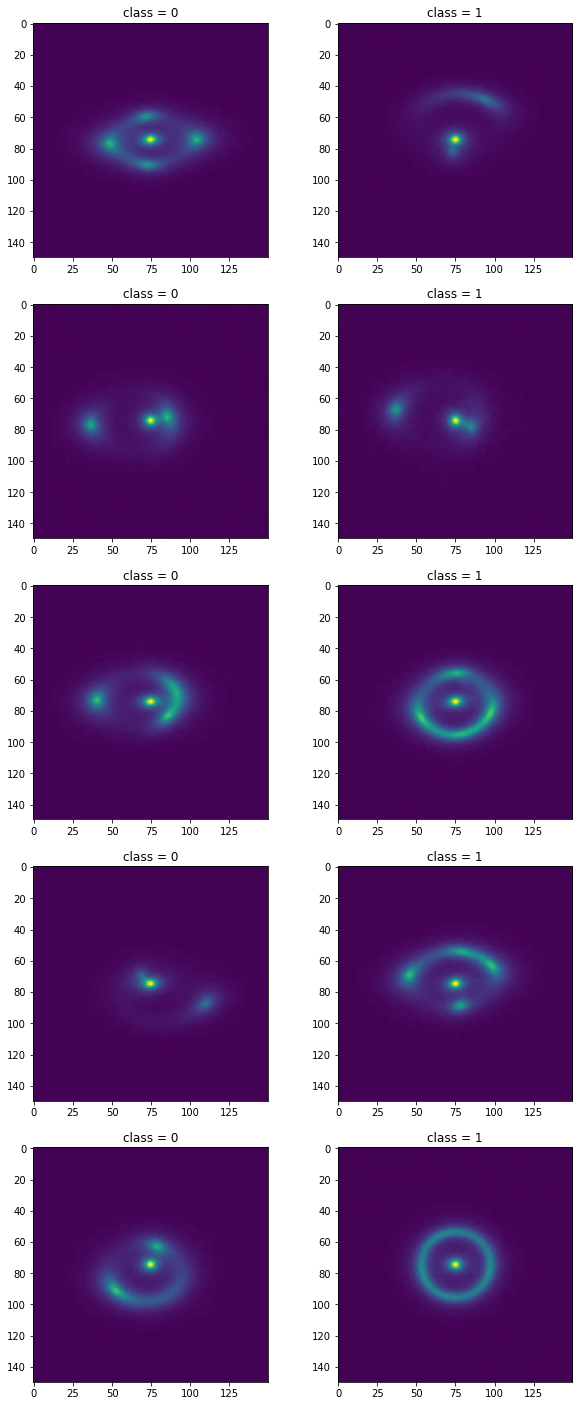

In [19]:
def get_n_random_from_class(_class : int, n : int) -> list:
  class_filepath = os.path.join(np_images_filepath, class_to_label[_class])
  files = [os.path.join(class_filepath, f) for f in os.listdir(class_filepath)]
  idxes = np.random.permutation(np.arange(0, len(files)))[:n]

  return [(_class, files[i]) for i in idxes]

v = 5
scale = 5

no_sub = get_n_random_from_class(0, v)
sub = get_n_random_from_class(1, v)
plt.figure(figsize=(2  *scale, v * scale))

for i in range(v):
    cls1 = no_sub[i][0]
    cls2 = sub[i][0]
    fpath1 = no_sub[i][1]
    fpath2 = sub[i][1]

    img1 = torchvision.io.read_image(fpath1).numpy()
    img2 = torchvision.io.read_image(fpath2).numpy()

    plt.subplot(v, 2, 2 *i + 1)
    plt.imshow(img1.transpose(1, 2, 0))
    plt.title(f"class = {cls1}")

    plt.subplot(v, 2, 2 *i + 2)
    plt.imshow(img2.transpose(1, 2, 0))
    plt.title(f"class = {cls2}")


plt.show()

### create a validation dataset

In [39]:
DEBUG = False
VALIDATION_PORTION = 0.1


def move_random_subsample_from_to(_from : str, _to : str):
  files = os.listdir(os.path.join(_from))
  print(f"found : {len(files)} files")
  VAL_FILES = int(len(files) * VALIDATION_PORTION)
  to_move = np.random.permutation(np.arange(len(files)))[:VAL_FILES]
  os.makedirs(_to,exist_ok=True)
  print(f"to move : {len(to_move)}")

  for idx in tqdm(to_move):
    orig = os.path.join(_from, files[idx])
    dest = os.path.join(_to, files[idx])

    if DEBUG:
      print(f"move {orig} -> {dest}")
    else:
      os.system(f"mv {orig} {dest}")

  print("After move : ")
  print(f"Training dataset size : {len(os.listdir(os.path.join(_from)))}")
  print(f"Validation dataset size : {len(os.listdir(os.path.join(_to)))}")


move_random_subsample_from_to(os.path.join("lenses","no_sub"), os.path.join("lenses_val", "no_sub"))
move_random_subsample_from_to(os.path.join("lenses","sub"), os.path.join("lenses_val", "sub"))

found : 5000 files
to move : 500


100%|██████████| 500/500 [00:00<00:00, 605.23it/s]


After move : 
Training dataset size : 4500
Validation dataset size : 501
found : 5000 files
to move : 500


100%|██████████| 500/500 [00:00<00:00, 589.94it/s]

After move : 
Training dataset size : 4500
Validation dataset size : 501


# Pytorch dataset creation 

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device Used : {device}")

Device Used : cuda:0


In [70]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

"""
# For small dataset 
mean = np.array([0.00782386,0.00482207,0.00304506])
std = np.array([0.63704916,0.18686025,0.04598732])
"""

# Large dataset
mean = np.array([0.022538540984749413])
std = np.array([0.06030143571638838])

tr = transforms.Compose([
    transforms.Normalize(mean[0], std[0]),
    transforms.Resize(size=(128,128))])

def load_npy(path : str) -> torch.Tensor:
    # load from sparse representation
    img = torchvision.io.read_image(path) / 255.
    
    # normalize the image

    return tr(img)

train_ds = DatasetFolder(os.path.join(".", "lenses"), extensions=[".jpg"], loader=load_npy)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

val_ds = DatasetFolder(os.path.join(".","lenses_val"), extensions=[".jpg"], loader=load_npy)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=True)

In [71]:
print(f"size of training : {len(train_ds)}")
print(f"size of validation : {len(val_ds)}")

size of training : 9000
size of validation : 1000


In [68]:
next(iter(train_dl))[0].shape

torch.Size([32, 1, 128, 128])

# Pytorch Functions

## Evaluate Model 
take a model, dataloader and size of dataset and report final metrics (accuracy and AUC )

In [46]:
def evaluate_model(model, valid_dataset, valid_dataset_len):
    since = time.time()

    # Each epoch has a training and validation phase
    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0
    y = torch.Tensor()
    pred_y = torch.Tensor()
    criterion = F.binary_cross_entropy

    # Iterate over data.
    for inputs, labels in tqdm(valid_dataset):
        inputs = inputs.to(device).float()
        labels = labels.to(device)
        labels = labels.long()
        y = torch.cat([y, labels.cpu()])
        
        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            pred_labels = (outputs >= 0.5).reshape(-1)
            # probs, preds = torch.max(outputs, 1)
  
            loss = criterion(outputs, labels.reshape(-1, 1).to(torch.float32))
            pred_y = torch.cat([pred_y, outputs.cpu()])

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(pred_labels == labels.data)

    epoch_loss = running_loss / valid_dataset_len
    epoch_acc = running_corrects.double() / valid_dataset_len
    AUC_ROC = roc_auc_score(y.detach().numpy(), pred_y.detach().numpy())  
    
    time_elapsed = time.time() - since
    print(f'VALIDATION : Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} AUC ROC : {AUC_ROC:.4f} Time taken : {round(time.time() - since, 2)}')
    return {"loss" : epoch_loss, "accuracy" : epoch_acc.item(), "AUC_ROC" : AUC_ROC}

## Train for number of epochs function



In [47]:
def training_epoch(model, optimizer, scheduler, 
                   train_dataloader, train_dataset_size,
                   valid_dataloader, valid_dataset_size, 
                   num_epochs=25, update_every=5,
                   clean_every = 10,
                   save_path=os.path.join(model_save_folder, 'model_AUC={}.pth')):
    since = time.time()

    returnDict = {"trainingLoss" : [], "trainingAccuracy" : [], "epochs" : [], "trainingAUC" : [],
                  "validationLoss" : [], "validationAccuracy" : [], "validationAUC" : []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    criterion = F.binary_cross_entropy
    best_AUC_score = 0
    model_best = copy.deepcopy(model.state_dict())
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        returnDict["epochs"].append(epoch)

        since2 = time.time()
        model.train()  # Set model to training mode

        running_loss = 0.0
        running_corrects = 0
        y = torch.Tensor()
        pred_y = torch.Tensor()

        i = 0
        samples_so_far = 0
        # Iterate over data.
        progress_bar = tqdm(train_dataloader)
        for inputs, labels in progress_bar:
            i += 1
            samples_so_far += inputs.shape[0]
            inputs = inputs.to(device).float()
            labels = labels.to(device)
            labels = labels.long()

            y = torch.cat([y, labels.cpu()])
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                pred_labels = (outputs >= 0.5).reshape(-1)

                loss = criterion(outputs, labels.reshape(-1, 1).to(torch.float32))
                pred_y = torch.cat([pred_y, outputs.cpu()])

                # backward + optimize only if in training phase
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(pred_labels == labels.data)

            if i % update_every == 0:
                rl_avg = running_loss / samples_so_far
                acc_avg = running_corrects / samples_so_far
                AUC_ROC = roc_auc_score(y.detach().numpy(), pred_y.detach().numpy()) 

                progress_bar.set_description(f"loss = {rl_avg}, accuracy : {acc_avg}, AUC ROC {AUC_ROC}")
            
            if clean_every != -1 and i % clean_every == 0:
                gc.collect()

            scheduler.step()
            
        epoch_loss = running_loss / train_dataset_size
        epoch_acc = running_corrects.double() / train_dataset_size
        AUC_ROC = roc_auc_score(y.detach().numpy(), pred_y.detach().numpy()) 

        returnDict["trainingLoss"].append(epoch_loss)
        returnDict["trainingAccuracy"].append(epoch_acc.cpu().item())
        returnDict["trainingAUC"].append(AUC_ROC)

        print(f'TRAINING ; Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} AUC ROC : {AUC_ROC:.4f} Time taken : {round(time.time() - since2, 2)}')
        eval_result = evaluate_model(model, valid_dataloader, valid_dataset_size)

        returnDict["validationLoss"].append(eval_result["loss"])
        returnDict["validationAccuracy"].append(eval_result["accuracy"])
        returnDict["validationAUC"].append(eval_result["AUC_ROC"])

        if eval_result["AUC_ROC"] > best_AUC_score:
          torch.save(model.state_dict(),save_path.format(round(eval_result["AUC_ROC"], 3)))
          best_AUC_score = eval_result["AUC_ROC"]
          model_best = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    # load best model weights
    returnDict["best_model"] = model_best
    return returnDict

## Plot the results

In [75]:
def plotResults(results):
    plt.figure(figsize=(16,12))
    plt.subplot(3,1, 1)
    plt.plot(results['epochs'], results['trainingLoss'], label="training Loss")
    plt.plot(results['epochs'], results['validationLoss'], label="validation Loss")
    plt.legend()

    plt.subplot(3,1, 2)
    plt.plot(results['epochs'], results['trainingAccuracy'], label="training Accuracy")
    plt.plot(results['epochs'], results['validationAccuracy'], label="validation Accuracy")
    plt.ylim((0, 1.))
    plt.legend()
  
  
    plt.subplot(3, 1, 3)
    plt.plot(results['epochs'], results['trainingAUC'], label="training ROC")
    plt.plot(results['epochs'], results['validationAUC'], label="validation AUC ROC")
    plt.ylim((0.5, 1.))
    plt.legend()

    plt.show()


## Do Experiment
train a model for a given number of epochs, with Adam optimizer with set learning rate


In [76]:
def doExperiment(model_ft, epochs=10, learning_rate=1e-3, plot=True, 
                 _summary=True, input_size=(3,32,32),
                 clean_every=100, nameOfModel="model_AUC={}.pth"):
  global train_dl, train_ds, val_dl, val_ds
  if _summary:
    print(summary(model_ft, input_size=input_size, device="cpu"))
  
  model_ft = model_ft.to(device)
  optim = pt_optim.Adam(model_ft.parameters(), lr=learning_rate)
  lr_sched = pt_lr_scheduler.CyclicLR(optim, learning_rate, 5 * learning_rate, 
                                      cycle_momentum=False, step_size_up =len(train_ds))

  dats = training_epoch(model_ft, optim, lr_sched, 
                        train_dl,  len(train_ds) , 
                        val_dl, len(val_ds),
                        num_epochs=epochs,
                        clean_every=clean_every,
                        save_path=os.path.join(model_save_folder, nameOfModel))
  
  if plot:
    plotResults(dats)
  return dats

# Train Transformers

## MobileVit 

### Architecutre

In [77]:
import torch
import torch.nn as nn

from einops import rearrange
from einops.layers.torch import Reduce

# helpers

def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )

def conv_nxn_bn(inp, oup, kernal_size=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernal_size, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(
            t, 'b p n (h d) -> b p h n d', h=self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b p h n d -> b p n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    """Transformer block described in ViT.
    Paper: https://arxiv.org/abs/2010.11929
    Based on: https://github.com/lucidrains/vit-pytorch
    """

    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads, dim_head, dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class MV2Block(nn.Module):
    """MV2 block described in MobileNetV2.
    Paper: https://arxiv.org/pdf/1801.04381
    Based on: https://github.com/tonylins/pytorch-mobilenet-v2
    """

    def __init__(self, inp, oup, stride=1, expansion=4):
        super().__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(inp * expansion)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expansion == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride,
                          1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride,
                          1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        out = self.conv(x)
        if self.use_res_connect:
            out = out + x
        return out

class MobileViTBlock(nn.Module):
    def __init__(self, dim, depth, channel, kernel_size, patch_size, mlp_dim, dropout=0.):
        super().__init__()
        self.ph, self.pw = patch_size

        self.conv1 = conv_nxn_bn(channel, channel, kernel_size)
        self.conv2 = conv_1x1_bn(channel, dim)

        self.transformer = Transformer(dim, depth, 4, 8, mlp_dim, dropout)

        self.conv3 = conv_1x1_bn(dim, channel)
        self.conv4 = conv_nxn_bn(2 * channel, channel, kernel_size)

    def forward(self, x):
        y = x.clone()

        # Local representations
        x = self.conv1(x)
        x = self.conv2(x)

        # Global representations
        _, _, h, w = x.shape
        x = rearrange(x, 'b d (h ph) (w pw) -> b (ph pw) (h w) d',
                      ph=self.ph, pw=self.pw)
        x = self.transformer(x)
        x = rearrange(x, 'b (ph pw) (h w) d -> b d (h ph) (w pw)',
                      h=h//self.ph, w=w//self.pw, ph=self.ph, pw=self.pw)

        # Fusion
        x = self.conv3(x)
        x = torch.cat((x, y), 1)
        x = self.conv4(x)
        return x

class MobileViT2(nn.Module):
    """MobileViT.
    Paper: https://arxiv.org/abs/2110.02178
    Based on: https://github.com/chinhsuanwu/mobilevit-pytorch
    """

    def __init__(
        self,
        image_size,
        dims,
        channels,
        num_classes,
        expansion=4,
        kernel_size=3,
        patch_size=(2, 2),
        depths=(2, 4, 3)
    ):
        super().__init__()
        assert len(dims) == 3, 'dims must be a tuple of 3'
        assert len(depths) == 3, 'depths must be a tuple of 3'

        ih, iw = image_size
        ph, pw = patch_size
        assert ih % ph == 0 and iw % pw == 0

        init_dim, *_, last_dim = channels

        self.conv1 = conv_nxn_bn(1, init_dim, stride=2)

        self.stem = nn.ModuleList([])
        self.stem.append(MV2Block(channels[0], channels[1], 1, expansion))
        self.stem.append(MV2Block(channels[1], channels[2], 2, expansion))


        self.trunk = nn.ModuleList([])
        self.trunk.append(nn.ModuleList([
            MV2Block(channels[2], channels[3], 2, expansion),
            MobileViTBlock(dims[0], depths[0], channels[len(channels)-1],
                           kernel_size, patch_size, int(dims[0] * 2))
        ]))

        self.head = nn.Sequential(
            conv_1x1_bn(channels[-2], last_dim),
            Reduce('b c h w -> b c', 'mean'),
            nn.Linear(channels[-1], num_classes, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)

        for conv in self.stem:
            x = conv(x)

        for conv, attn in self.trunk:
            x = conv(x)
            x = attn(x)

        return self.head(x)


### Experiment 1

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             288
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              SiLU-3           [-1, 32, 64, 64]               0
            Conv2d-4          [-1, 128, 64, 64]           4,096
       BatchNorm2d-5          [-1, 128, 64, 64]             256
              SiLU-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 128, 64, 64]           1,152
       BatchNorm2d-8          [-1, 128, 64, 64]             256
              SiLU-9          [-1, 128, 64, 64]               0
           Conv2d-10           [-1, 32, 64, 64]           4,096
      BatchNorm2d-11           [-1, 32, 64, 64]              64
         MV2Block-12           [-1, 32, 64, 64]               0
           Conv2d-13          [-1, 128, 64, 64]           4,096
      BatchNorm2d-14          [-1, 128,

loss = 0.5756206388984407, accuracy : 0.6974330544471741, AUC ROC 0.7870322109689997: 100%|██████████| 282/282 [00:17<00:00, 15.91it/s]


TRAINING ; Loss: 0.5744 Acc: 0.6983 AUC ROC : 0.7882 Time taken : 17.74


100%|██████████| 32/32 [00:01<00:00, 31.94it/s]


VALIDATION : Loss: 0.4803 Acc: 0.7700 AUC ROC : 0.9024 Time taken : 1.01
Epoch 1/14
----------


loss = 0.2974211367645434, accuracy : 0.8926339149475098, AUC ROC 0.9621601942243401: 100%|██████████| 282/282 [00:17<00:00, 16.02it/s]


TRAINING ; Loss: 0.2970 Acc: 0.8929 AUC ROC : 0.9623 Time taken : 17.64


100%|██████████| 32/32 [00:00<00:00, 32.55it/s]


VALIDATION : Loss: 0.3074 Acc: 0.8570 AUC ROC : 0.9822 Time taken : 0.99
Epoch 2/14
----------


loss = 0.16376589555293322, accuracy : 0.9516741037368774, AUC ROC 0.9901898313033038: 100%|██████████| 282/282 [00:17<00:00, 16.21it/s]


TRAINING ; Loss: 0.1635 Acc: 0.9518 AUC ROC : 0.9902 Time taken : 17.42


100%|██████████| 32/32 [00:00<00:00, 32.30it/s]


VALIDATION : Loss: 0.1501 Acc: 0.9640 AUC ROC : 0.9937 Time taken : 1.0
Epoch 3/14
----------


loss = 0.10898282682257039, accuracy : 0.9688616394996643, AUC ROC 0.9958722246096549: 100%|██████████| 282/282 [00:17<00:00, 16.07it/s]


TRAINING ; Loss: 0.1089 Acc: 0.9688 AUC ROC : 0.9959 Time taken : 17.58


100%|██████████| 32/32 [00:01<00:00, 30.58it/s]


VALIDATION : Loss: 0.3368 Acc: 0.8340 AUC ROC : 0.9951 Time taken : 1.05
Epoch 4/14
----------


loss = 0.07595663889909961, accuracy : 0.9801339507102966, AUC ROC 0.9978116528724716: 100%|██████████| 282/282 [00:17<00:00, 15.97it/s]


TRAINING ; Loss: 0.0760 Acc: 0.9801 AUC ROC : 0.9978 Time taken : 17.69


100%|██████████| 32/32 [00:00<00:00, 32.01it/s]


VALIDATION : Loss: 0.1392 Acc: 0.9460 AUC ROC : 0.9895 Time taken : 1.01
Epoch 5/14
----------


loss = 0.06816747346892953, accuracy : 0.9814732074737549, AUC ROC 0.997820070626483: 100%|██████████| 282/282 [00:17<00:00, 16.07it/s]


TRAINING ; Loss: 0.0687 Acc: 0.9811 AUC ROC : 0.9978 Time taken : 17.58


100%|██████████| 32/32 [00:01<00:00, 31.27it/s]


VALIDATION : Loss: 0.1240 Acc: 0.9570 AUC ROC : 0.9956 Time taken : 1.03
Epoch 6/14
----------


loss = 0.06361276446509041, accuracy : 0.9794642925262451, AUC ROC 0.9980757732780613: 100%|██████████| 282/282 [00:17<00:00, 16.20it/s]


TRAINING ; Loss: 0.0635 Acc: 0.9794 AUC ROC : 0.9981 Time taken : 17.44


100%|██████████| 32/32 [00:01<00:00, 31.93it/s]


VALIDATION : Loss: 0.0610 Acc: 0.9830 AUC ROC : 0.9974 Time taken : 1.01
Epoch 7/14
----------


loss = 0.04277388547114762, accuracy : 0.9887276887893677, AUC ROC 0.9991360411352042: 100%|██████████| 282/282 [00:17<00:00, 16.17it/s]


TRAINING ; Loss: 0.0428 Acc: 0.9887 AUC ROC : 0.9991 Time taken : 17.47


100%|██████████| 32/32 [00:01<00:00, 31.49it/s]


VALIDATION : Loss: 0.1060 Acc: 0.9600 AUC ROC : 0.9923 Time taken : 1.02
Epoch 8/14
----------


loss = 0.06339518758800945, accuracy : 0.9782366156578064, AUC ROC 0.9976042829241071: 100%|██████████| 282/282 [00:17<00:00, 16.16it/s]


TRAINING ; Loss: 0.0634 Acc: 0.9782 AUC ROC : 0.9976 Time taken : 17.48


100%|██████████| 32/32 [00:00<00:00, 32.23it/s]


VALIDATION : Loss: 0.1080 Acc: 0.9550 AUC ROC : 0.9958 Time taken : 1.0
Epoch 9/14
----------


loss = 0.03553663509249288, accuracy : 0.9908482432365417, AUC ROC 0.9994135642246076: 100%|██████████| 282/282 [00:17<00:00, 16.02it/s]


TRAINING ; Loss: 0.0358 Acc: 0.9908 AUC ROC : 0.9994 Time taken : 17.64


100%|██████████| 32/32 [00:01<00:00, 30.00it/s]


VALIDATION : Loss: 0.0831 Acc: 0.9730 AUC ROC : 0.9967 Time taken : 1.07
Epoch 10/14
----------


loss = 0.054646686913578636, accuracy : 0.9813616275787354, AUC ROC 0.9981173236319979: 100%|██████████| 282/282 [00:17<00:00, 16.05it/s]


TRAINING ; Loss: 0.0545 Acc: 0.9814 AUC ROC : 0.9981 Time taken : 17.6


100%|██████████| 32/32 [00:00<00:00, 32.74it/s]


VALIDATION : Loss: 0.0645 Acc: 0.9790 AUC ROC : 0.9966 Time taken : 0.99
Epoch 11/14
----------


loss = 0.035253291801616016, accuracy : 0.9880580306053162, AUC ROC 0.9993695690852983: 100%|██████████| 282/282 [00:17<00:00, 16.18it/s]


TRAINING ; Loss: 0.0352 Acc: 0.9880 AUC ROC : 0.9994 Time taken : 17.46


100%|██████████| 32/32 [00:01<00:00, 31.39it/s]


VALIDATION : Loss: 0.0833 Acc: 0.9730 AUC ROC : 0.9987 Time taken : 1.03
Epoch 12/14
----------


loss = 0.03064402358036854, accuracy : 0.9909598231315613, AUC ROC 0.9993078859300748: 100%|██████████| 282/282 [00:17<00:00, 16.19it/s]


TRAINING ; Loss: 0.0308 Acc: 0.9909 AUC ROC : 0.9993 Time taken : 17.45


100%|██████████| 32/32 [00:00<00:00, 32.20it/s]


VALIDATION : Loss: 0.0704 Acc: 0.9790 AUC ROC : 0.9985 Time taken : 1.0
Epoch 13/14
----------


loss = 0.039948553316727545, accuracy : 0.9871652126312256, AUC ROC 0.9989793925382652: 100%|██████████| 282/282 [00:17<00:00, 16.09it/s]


TRAINING ; Loss: 0.0400 Acc: 0.9871 AUC ROC : 0.9990 Time taken : 17.56


100%|██████████| 32/32 [00:01<00:00, 31.89it/s]


VALIDATION : Loss: 0.5791 Acc: 0.8150 AUC ROC : 0.9956 Time taken : 1.01
Epoch 14/14
----------


loss = 0.038135880619354016, accuracy : 0.9860491156578064, AUC ROC 0.9991779928077111: 100%|██████████| 282/282 [00:17<00:00, 16.05it/s]


TRAINING ; Loss: 0.0380 Acc: 0.9861 AUC ROC : 0.9992 Time taken : 17.61


100%|██████████| 32/32 [00:01<00:00, 31.99it/s]


VALIDATION : Loss: 0.1022 Acc: 0.9590 AUC ROC : 0.9975 Time taken : 1.01
Training complete in 4m 39s


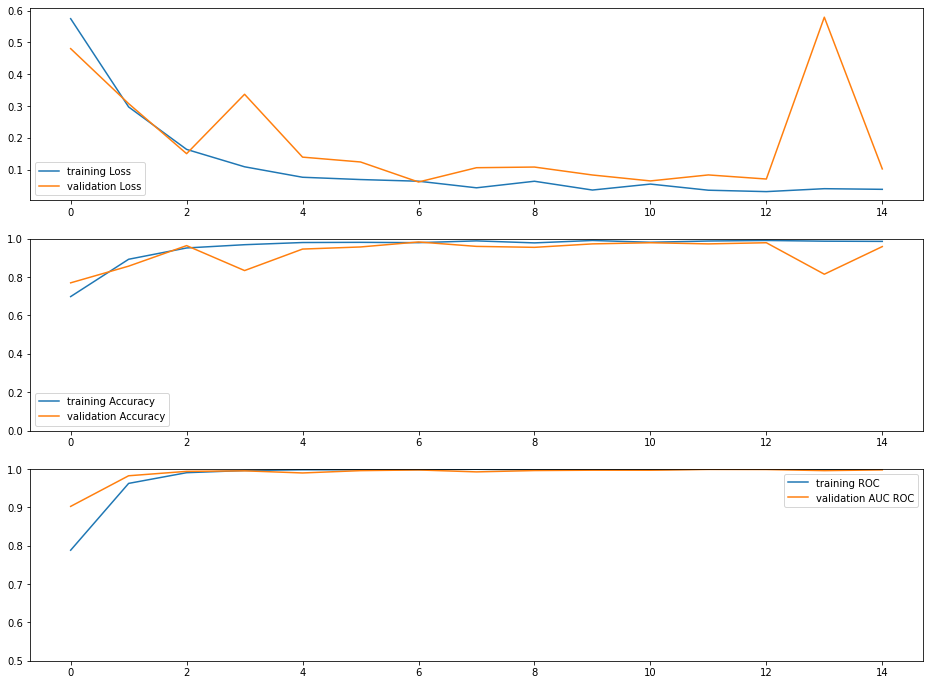

In [79]:
mobileVit1 = doExperiment(MobileViT2(image_size = (128, 128),
                        dims = [32, 48, 64],
                        channels = [32, 32, 48, 96, 96],
                        num_classes = 1,
                        patch_size=(8, 8),
                        kernel_size=3,
                        depths=(1, 2, 1)), 
             learning_rate=1e-4,
             input_size=(1,128,128),
             clean_every=500,
             epochs=15,
             nameOfModel="MobileViT_AUC={}.pth")

### Experiment 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             288
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              SiLU-3           [-1, 32, 64, 64]               0
            Conv2d-4          [-1, 128, 64, 64]           4,096
       BatchNorm2d-5          [-1, 128, 64, 64]             256
              SiLU-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 128, 64, 64]           1,152
       BatchNorm2d-8          [-1, 128, 64, 64]             256
              SiLU-9          [-1, 128, 64, 64]               0
           Conv2d-10           [-1, 32, 64, 64]           4,096
      BatchNorm2d-11           [-1, 32, 64, 64]              64
         MV2Block-12           [-1, 32, 64, 64]               0
           Conv2d-13          [-1, 128, 64, 64]           4,096
      BatchNorm2d-14          [-1, 128,

loss = 0.5922338967876775, accuracy : 0.6772321462631226, AUC ROC 0.7577437299577352: 100%|██████████| 282/282 [00:18<00:00, 15.37it/s]


TRAINING ; Loss: 0.5916 Acc: 0.6778 AUC ROC : 0.7584 Time taken : 18.35


100%|██████████| 32/32 [00:01<00:00, 30.91it/s]


VALIDATION : Loss: 0.4725 Acc: 0.7680 AUC ROC : 0.8640 Time taken : 1.04
Epoch 1/9
----------


loss = 0.29891693810267106, accuracy : 0.8941964507102966, AUC ROC 0.9614855726412685: 100%|██████████| 282/282 [00:18<00:00, 15.42it/s]


TRAINING ; Loss: 0.2990 Acc: 0.8943 AUC ROC : 0.9614 Time taken : 18.33


100%|██████████| 32/32 [00:01<00:00, 30.58it/s]


VALIDATION : Loss: 0.2615 Acc: 0.8940 AUC ROC : 0.9712 Time taken : 1.05
Epoch 2/9
----------


loss = 0.17337218315473624, accuracy : 0.9437500238418579, AUC ROC 0.9875237663424745: 100%|██████████| 282/282 [00:18<00:00, 15.14it/s]


TRAINING ; Loss: 0.1737 Acc: 0.9433 AUC ROC : 0.9874 Time taken : 18.66


100%|██████████| 32/32 [00:01<00:00, 29.14it/s]


VALIDATION : Loss: 0.2964 Acc: 0.8520 AUC ROC : 0.9876 Time taken : 1.11
Epoch 3/9
----------


loss = 0.11020612978775586, accuracy : 0.9659598469734192, AUC ROC 0.9956074866470026: 100%|██████████| 282/282 [00:18<00:00, 15.63it/s]


TRAINING ; Loss: 0.1100 Acc: 0.9660 AUC ROC : 0.9956 Time taken : 18.08


100%|██████████| 32/32 [00:01<00:00, 31.96it/s]


VALIDATION : Loss: 0.1214 Acc: 0.9580 AUC ROC : 0.9946 Time taken : 1.01
Epoch 4/9
----------


loss = 0.08172318047976919, accuracy : 0.9753348231315613, AUC ROC 0.9973798681478822: 100%|██████████| 282/282 [00:18<00:00, 15.63it/s]


TRAINING ; Loss: 0.0817 Acc: 0.9752 AUC ROC : 0.9974 Time taken : 18.08


100%|██████████| 32/32 [00:01<00:00, 30.57it/s]


VALIDATION : Loss: 0.1506 Acc: 0.9430 AUC ROC : 0.9915 Time taken : 1.06
Epoch 5/9
----------


loss = 0.05768345777677106, accuracy : 0.9839285612106323, AUC ROC 0.9987933972417092: 100%|██████████| 282/282 [00:17<00:00, 15.71it/s]


TRAINING ; Loss: 0.0575 Acc: 0.9840 AUC ROC : 0.9988 Time taken : 17.99


100%|██████████| 32/32 [00:00<00:00, 32.06it/s]


VALIDATION : Loss: 0.1971 Acc: 0.9150 AUC ROC : 0.9891 Time taken : 1.01
Epoch 6/9
----------


loss = 0.053822099018309796, accuracy : 0.9842634201049805, AUC ROC 0.9988197535234005: 100%|██████████| 282/282 [00:18<00:00, 15.48it/s]


TRAINING ; Loss: 0.0537 Acc: 0.9843 AUC ROC : 0.9988 Time taken : 18.25


100%|██████████| 32/32 [00:01<00:00, 31.79it/s]


VALIDATION : Loss: 0.1321 Acc: 0.9440 AUC ROC : 0.9953 Time taken : 1.01
Epoch 7/9
----------


loss = 0.04531604786336954, accuracy : 0.9849330186843872, AUC ROC 0.9990019124696369: 100%|██████████| 282/282 [00:18<00:00, 15.48it/s]


TRAINING ; Loss: 0.0452 Acc: 0.9850 AUC ROC : 0.9990 Time taken : 18.25


100%|██████████| 32/32 [00:01<00:00, 31.42it/s]


VALIDATION : Loss: 0.2086 Acc: 0.9260 AUC ROC : 0.9946 Time taken : 1.03
Epoch 8/9
----------


loss = 0.03957251923192026, accuracy : 0.9876115918159485, AUC ROC 0.9992242303600363: 100%|██████████| 282/282 [00:18<00:00, 15.47it/s]


TRAINING ; Loss: 0.0396 Acc: 0.9876 AUC ROC : 0.9992 Time taken : 18.26


100%|██████████| 32/32 [00:01<00:00, 31.49it/s]


VALIDATION : Loss: 0.3691 Acc: 0.8510 AUC ROC : 0.9972 Time taken : 1.03
Epoch 9/9
----------


loss = 0.05204524010769092, accuracy : 0.9831473231315613, AUC ROC 0.998387624835012: 100%|██████████| 282/282 [00:18<00:00, 15.61it/s]


TRAINING ; Loss: 0.0522 Acc: 0.9831 AUC ROC : 0.9984 Time taken : 18.1


100%|██████████| 32/32 [00:01<00:00, 31.99it/s]


VALIDATION : Loss: 0.0785 Acc: 0.9710 AUC ROC : 0.9964 Time taken : 1.01
Training complete in 3m 13s


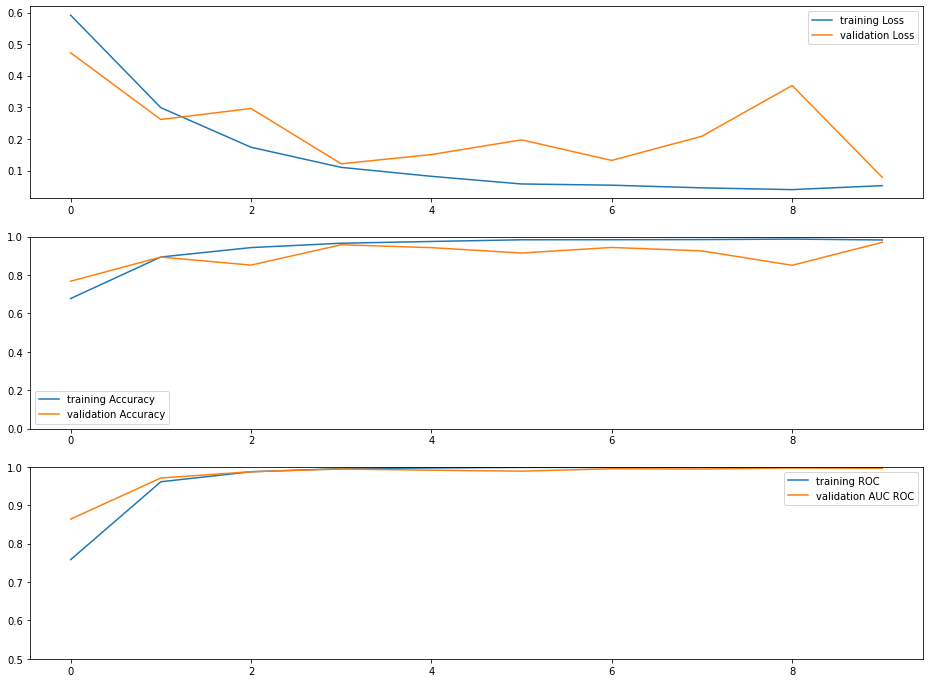

In [80]:
mobileVit1 = doExperiment(MobileViT2(image_size = (128, 128),
                        dims = [32, 48, 64],
                        channels = [32, 32, 48, 96, 96],
                        num_classes = 1,
                        patch_size=(8, 8),
                        kernel_size=3,
                        depths=(2, 4, 2)), 
             learning_rate=1e-4,
             input_size=(1,128,128),
             clean_every=500,
             epochs=10,
             nameOfModel="MobileViT2_AUC={}.pth")

### Experiment 3

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             288
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              SiLU-3           [-1, 32, 64, 64]               0
            Conv2d-4          [-1, 128, 64, 64]           4,096
       BatchNorm2d-5          [-1, 128, 64, 64]             256
              SiLU-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 128, 64, 64]           1,152
       BatchNorm2d-8          [-1, 128, 64, 64]             256
              SiLU-9          [-1, 128, 64, 64]               0
           Conv2d-10           [-1, 32, 64, 64]           4,096
      BatchNorm2d-11           [-1, 32, 64, 64]              64
         MV2Block-12           [-1, 32, 64, 64]               0
           Conv2d-13          [-1, 128, 64, 64]           4,096
      BatchNorm2d-14          [-1, 128,

loss = 0.5352109443928514, accuracy : 0.7180803418159485, AUC ROC 0.8136258877757396: 100%|██████████| 282/282 [00:17<00:00, 15.70it/s]


TRAINING ; Loss: 0.5338 Acc: 0.7191 AUC ROC : 0.8150 Time taken : 17.97


100%|██████████| 32/32 [00:01<00:00, 31.11it/s]


VALIDATION : Loss: 0.3225 Acc: 0.8660 AUC ROC : 0.9668 Time taken : 1.04
Epoch 1/9
----------


loss = 0.21231784775320972, accuracy : 0.9264509081840515, AUC ROC 0.9779305070283939: 100%|██████████| 282/282 [00:18<00:00, 15.46it/s]


TRAINING ; Loss: 0.2120 Acc: 0.9267 AUC ROC : 0.9780 Time taken : 18.27


100%|██████████| 32/32 [00:01<00:00, 30.72it/s]


VALIDATION : Loss: 0.2076 Acc: 0.9190 AUC ROC : 0.9919 Time taken : 1.05
Epoch 2/9
----------


loss = 0.1316638479541455, accuracy : 0.9559152126312256, AUC ROC 0.9913828320004998: 100%|██████████| 282/282 [00:18<00:00, 15.23it/s]


TRAINING ; Loss: 0.1316 Acc: 0.9560 AUC ROC : 0.9914 Time taken : 18.54


100%|██████████| 32/32 [00:01<00:00, 30.76it/s]


VALIDATION : Loss: 0.1412 Acc: 0.9500 AUC ROC : 0.9916 Time taken : 1.05
Epoch 3/9
----------


loss = 0.08486316426258002, accuracy : 0.9738839268684387, AUC ROC 0.9966993103409102: 100%|██████████| 282/282 [00:17<00:00, 16.09it/s]


TRAINING ; Loss: 0.0850 Acc: 0.9739 AUC ROC : 0.9967 Time taken : 17.56


100%|██████████| 32/32 [00:00<00:00, 32.34it/s]


VALIDATION : Loss: 0.1320 Acc: 0.9470 AUC ROC : 0.9931 Time taken : 1.0
Epoch 4/9
----------


loss = 0.06934720606410077, accuracy : 0.9782366156578064, AUC ROC 0.9975623305963012: 100%|██████████| 282/282 [00:17<00:00, 16.15it/s]


TRAINING ; Loss: 0.0694 Acc: 0.9782 AUC ROC : 0.9976 Time taken : 17.49


100%|██████████| 32/32 [00:00<00:00, 32.48it/s]


VALIDATION : Loss: 0.1108 Acc: 0.9630 AUC ROC : 0.9930 Time taken : 0.99
Epoch 5/9
----------


loss = 0.05700177880935371, accuracy : 0.9802455306053162, AUC ROC 0.9980860367677847: 100%|██████████| 282/282 [00:17<00:00, 16.02it/s]


TRAINING ; Loss: 0.0570 Acc: 0.9802 AUC ROC : 0.9981 Time taken : 17.64


100%|██████████| 32/32 [00:00<00:00, 32.65it/s]


VALIDATION : Loss: 0.0711 Acc: 0.9780 AUC ROC : 0.9972 Time taken : 0.99
Epoch 6/9
----------


loss = 0.05283746774907091, accuracy : 0.983593761920929, AUC ROC 0.9981461241598566: 100%|██████████| 282/282 [00:17<00:00, 16.11it/s]


TRAINING ; Loss: 0.0532 Acc: 0.9833 AUC ROC : 0.9981 Time taken : 17.53


100%|██████████| 32/32 [00:00<00:00, 32.13it/s]


VALIDATION : Loss: 0.0665 Acc: 0.9760 AUC ROC : 0.9982 Time taken : 1.01
Epoch 7/9
----------


loss = 0.05233051330599535, accuracy : 0.9813616275787354, AUC ROC 0.9983422844128945: 100%|██████████| 282/282 [00:17<00:00, 16.09it/s]


TRAINING ; Loss: 0.0525 Acc: 0.9812 AUC ROC : 0.9983 Time taken : 17.55


100%|██████████| 32/32 [00:01<00:00, 31.30it/s]


VALIDATION : Loss: 0.1128 Acc: 0.9540 AUC ROC : 0.9982 Time taken : 1.03
Epoch 8/9
----------


loss = 0.05070368921733461, accuracy : 0.981808066368103, AUC ROC 0.9983346108375406: 100%|██████████| 282/282 [00:17<00:00, 16.03it/s]


TRAINING ; Loss: 0.0507 Acc: 0.9818 AUC ROC : 0.9983 Time taken : 17.63


100%|██████████| 32/32 [00:01<00:00, 31.66it/s]


VALIDATION : Loss: 0.5867 Acc: 0.8530 AUC ROC : 0.9938 Time taken : 1.02
Epoch 9/9
----------


loss = 0.04181347434142871, accuracy : 0.9863839149475098, AUC ROC 0.9989000217036077: 100%|██████████| 282/282 [00:17<00:00, 16.15it/s]


TRAINING ; Loss: 0.0418 Acc: 0.9863 AUC ROC : 0.9989 Time taken : 17.49


100%|██████████| 32/32 [00:00<00:00, 32.07it/s]


VALIDATION : Loss: 0.1285 Acc: 0.9500 AUC ROC : 0.9985 Time taken : 1.01
Training complete in 3m 8s


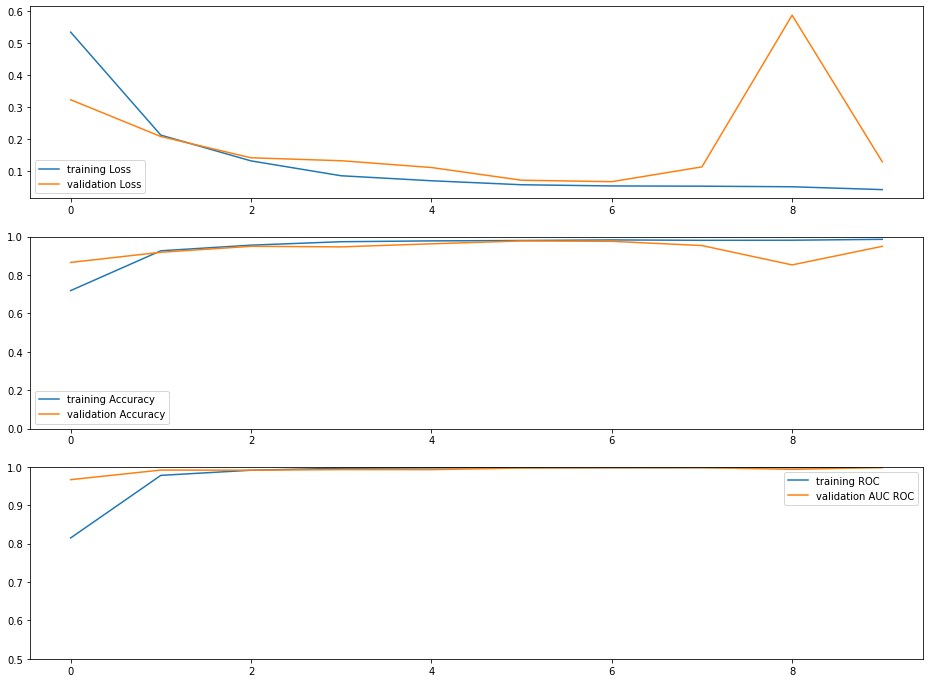

In [81]:
mobileVit1 = doExperiment(MobileViT2(image_size = (128, 128),
                        dims = [32, 48, 64],
                        channels = [32, 32, 48, 96, 96],
                        num_classes = 1,
                        patch_size=(4, 4),
                        kernel_size=3,
                        depths=(1, 2, 1)), 
             learning_rate=1e-4,
             input_size=(1,128,128),
             clean_every=500,
             epochs=10,
             nameOfModel="MobileViT3_AUC={}.pth")

### Experiment 4

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             288
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              SiLU-3           [-1, 32, 64, 64]               0
            Conv2d-4          [-1, 128, 64, 64]           4,096
       BatchNorm2d-5          [-1, 128, 64, 64]             256
              SiLU-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 128, 64, 64]           1,152
       BatchNorm2d-8          [-1, 128, 64, 64]             256
              SiLU-9          [-1, 128, 64, 64]               0
           Conv2d-10           [-1, 32, 64, 64]           4,096
      BatchNorm2d-11           [-1, 32, 64, 64]              64
         MV2Block-12           [-1, 32, 64, 64]               0
           Conv2d-13          [-1, 128, 64, 64]           4,096
      BatchNorm2d-14          [-1, 128,

loss = 0.47373498803270714, accuracy : 0.7526785731315613, AUC ROC 0.8533186682876277: 100%|██████████| 282/282 [00:18<00:00, 15.61it/s]


TRAINING ; Loss: 0.4727 Acc: 0.7536 AUC ROC : 0.8541 Time taken : 18.08


100%|██████████| 32/32 [00:01<00:00, 31.22it/s]


VALIDATION : Loss: 1.3400 Acc: 0.5120 AUC ROC : 0.8452 Time taken : 1.03
Epoch 1/9
----------


loss = 0.1908546878823212, accuracy : 0.9296875, AUC ROC 0.9821085555202631: 100%|██████████| 282/282 [00:18<00:00, 15.64it/s]


TRAINING ; Loss: 0.1908 Acc: 0.9296 AUC ROC : 0.9821 Time taken : 18.07


100%|██████████| 32/32 [00:01<00:00, 31.20it/s]


VALIDATION : Loss: 0.2465 Acc: 0.8840 AUC ROC : 0.9859 Time taken : 1.03
Epoch 2/9
----------


loss = 0.11804507384741945, accuracy : 0.9584821462631226, AUC ROC 0.9928479253029335: 100%|██████████| 282/282 [00:18<00:00, 15.62it/s]


TRAINING ; Loss: 0.1179 Acc: 0.9586 AUC ROC : 0.9929 Time taken : 18.09


100%|██████████| 32/32 [00:00<00:00, 32.14it/s]


VALIDATION : Loss: 0.1362 Acc: 0.9430 AUC ROC : 0.9955 Time taken : 1.0
Epoch 3/9
----------


loss = 0.08936512713719691, accuracy : 0.9685267806053162, AUC ROC 0.9957412898081334: 100%|██████████| 282/282 [00:17<00:00, 15.73it/s]


TRAINING ; Loss: 0.0894 Acc: 0.9684 AUC ROC : 0.9957 Time taken : 17.97


100%|██████████| 32/32 [00:01<00:00, 29.94it/s]


VALIDATION : Loss: 0.2719 Acc: 0.8790 AUC ROC : 0.9934 Time taken : 1.08
Epoch 4/9
----------


loss = 0.07187450263383133, accuracy : 0.9767857193946838, AUC ROC 0.9970591979472232: 100%|██████████| 282/282 [00:18<00:00, 15.64it/s]


TRAINING ; Loss: 0.0731 Acc: 0.9760 AUC ROC : 0.9969 Time taken : 18.07


100%|██████████| 32/32 [00:01<00:00, 30.62it/s]


VALIDATION : Loss: 0.1029 Acc: 0.9600 AUC ROC : 0.9974 Time taken : 1.05
Epoch 5/9
----------


loss = 0.06378684381156095, accuracy : 0.9758928418159485, AUC ROC 0.9976793177571877: 100%|██████████| 282/282 [00:18<00:00, 15.64it/s]


TRAINING ; Loss: 0.0638 Acc: 0.9759 AUC ROC : 0.9977 Time taken : 18.06


100%|██████████| 32/32 [00:01<00:00, 28.82it/s]


VALIDATION : Loss: 0.0678 Acc: 0.9750 AUC ROC : 0.9988 Time taken : 1.12
Epoch 6/9
----------


loss = 0.0551596648533762, accuracy : 0.9797990918159485, AUC ROC 0.9982370043343466: 100%|██████████| 282/282 [00:18<00:00, 15.54it/s]


TRAINING ; Loss: 0.0554 Acc: 0.9797 AUC ROC : 0.9982 Time taken : 18.19


100%|██████████| 32/32 [00:01<00:00, 31.93it/s]


VALIDATION : Loss: 0.1161 Acc: 0.9500 AUC ROC : 0.9966 Time taken : 1.01
Epoch 7/9
----------


loss = 0.044638049195054916, accuracy : 0.985156238079071, AUC ROC 0.9987389383694618: 100%|██████████| 282/282 [00:18<00:00, 15.46it/s]


TRAINING ; Loss: 0.0453 Acc: 0.9849 AUC ROC : 0.9987 Time taken : 18.27


100%|██████████| 32/32 [00:01<00:00, 30.72it/s]


VALIDATION : Loss: 0.2268 Acc: 0.9420 AUC ROC : 0.9856 Time taken : 1.05
Epoch 8/9
----------


loss = 0.06066079200744363, accuracy : 0.9780133962631226, AUC ROC 0.9975368202694924: 100%|██████████| 282/282 [00:18<00:00, 15.61it/s]


TRAINING ; Loss: 0.0607 Acc: 0.9780 AUC ROC : 0.9975 Time taken : 18.1


100%|██████████| 32/32 [00:01<00:00, 31.10it/s]


VALIDATION : Loss: 0.0893 Acc: 0.9660 AUC ROC : 0.9979 Time taken : 1.04
Epoch 9/9
----------


loss = 0.03849867809913121, accuracy : 0.9870535731315613, AUC ROC 0.9990593349650916: 100%|██████████| 282/282 [00:18<00:00, 15.49it/s]


TRAINING ; Loss: 0.0391 Acc: 0.9867 AUC ROC : 0.9990 Time taken : 18.24


100%|██████████| 32/32 [00:01<00:00, 31.68it/s]


VALIDATION : Loss: 0.1747 Acc: 0.9310 AUC ROC : 0.9944 Time taken : 1.02
Training complete in 3m 12s


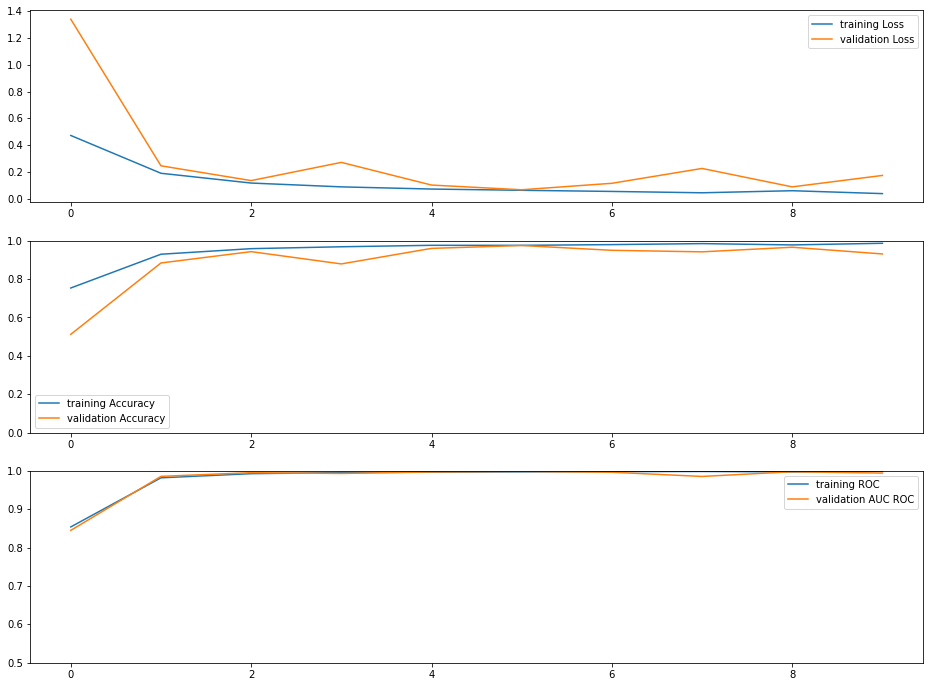

In [82]:
mobileVit1 = doExperiment(MobileViT2(image_size = (128, 128),
                        dims = [32, 48, 64],
                        channels = [32, 32, 48, 96, 96],
                        num_classes = 1,
                        patch_size=(2, 2),
                        kernel_size=3,
                        depths=(2, 4, 2)), 
             learning_rate=1e-4,
             input_size=(1,128,128),
             clean_every=500,
             epochs=10,
             nameOfModel="MobileViT4_AUC={}.pth")

### Experiment 5

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             288
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              SiLU-3           [-1, 32, 64, 64]               0
            Conv2d-4          [-1, 128, 64, 64]           4,096
       BatchNorm2d-5          [-1, 128, 64, 64]             256
              SiLU-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 128, 64, 64]           1,152
       BatchNorm2d-8          [-1, 128, 64, 64]             256
              SiLU-9          [-1, 128, 64, 64]               0
           Conv2d-10           [-1, 32, 64, 64]           4,096
      BatchNorm2d-11           [-1, 32, 64, 64]              64
         MV2Block-12           [-1, 32, 64, 64]               0
           Conv2d-13          [-1, 128, 64, 64]           4,096
      BatchNorm2d-14          [-1, 128,

loss = 0.6187854371964931, accuracy : 0.6503348350524902, AUC ROC 0.7234329415904255: 100%|██████████| 282/282 [00:18<00:00, 15.58it/s]


TRAINING ; Loss: 0.6187 Acc: 0.6502 AUC ROC : 0.7234 Time taken : 18.11


100%|██████████| 32/32 [00:00<00:00, 32.15it/s]


VALIDATION : Loss: 0.6082 Acc: 0.6410 AUC ROC : 0.7368 Time taken : 1.0
Epoch 1/9
----------


loss = 0.4541158583547388, accuracy : 0.801562488079071, AUC ROC 0.8896336425051106: 100%|██████████| 282/282 [00:18<00:00, 15.65it/s]


TRAINING ; Loss: 0.4541 Acc: 0.8017 AUC ROC : 0.8895 Time taken : 18.06


100%|██████████| 32/32 [00:01<00:00, 31.80it/s]


VALIDATION : Loss: 0.4980 Acc: 0.7300 AUC ROC : 0.8921 Time taken : 1.01
Epoch 2/9
----------


loss = 0.3264704019895622, accuracy : 0.8716517686843872, AUC ROC 0.9515241077170415: 100%|██████████| 282/282 [00:18<00:00, 15.64it/s]


TRAINING ; Loss: 0.3266 Acc: 0.8714 AUC ROC : 0.9514 Time taken : 18.07


100%|██████████| 32/32 [00:01<00:00, 31.84it/s]


VALIDATION : Loss: 0.3740 Acc: 0.8260 AUC ROC : 0.9404 Time taken : 1.01
Epoch 3/9
----------


loss = 0.23552590438297816, accuracy : 0.9176339507102966, AUC ROC 0.977236349594863: 100%|██████████| 282/282 [00:18<00:00, 15.61it/s]


TRAINING ; Loss: 0.2352 Acc: 0.9177 AUC ROC : 0.9773 Time taken : 18.1


100%|██████████| 32/32 [00:01<00:00, 31.92it/s]


VALIDATION : Loss: 0.3123 Acc: 0.8580 AUC ROC : 0.9428 Time taken : 1.01
Epoch 4/9
----------


loss = 0.1756098633632064, accuracy : 0.9433035850524902, AUC ROC 0.987370154530085: 100%|██████████| 282/282 [00:17<00:00, 15.77it/s]


TRAINING ; Loss: 0.1756 Acc: 0.9432 AUC ROC : 0.9874 Time taken : 17.91


100%|██████████| 32/32 [00:01<00:00, 31.11it/s]


VALIDATION : Loss: 0.2277 Acc: 0.9090 AUC ROC : 0.9744 Time taken : 1.04
Epoch 5/9
----------


loss = 0.137094916389989, accuracy : 0.9561383724212646, AUC ROC 0.9923082733394997: 100%|██████████| 282/282 [00:18<00:00, 15.62it/s]


TRAINING ; Loss: 0.1372 Acc: 0.9560 AUC ROC : 0.9923 Time taken : 18.09


100%|██████████| 32/32 [00:01<00:00, 31.42it/s]


VALIDATION : Loss: 0.5960 Acc: 0.7320 AUC ROC : 0.9197 Time taken : 1.03
Epoch 6/9
----------


loss = 0.10117598865181207, accuracy : 0.9727678894996643, AUC ROC 0.996102113544129: 100%|██████████| 282/282 [00:17<00:00, 15.78it/s]


TRAINING ; Loss: 0.1016 Acc: 0.9726 AUC ROC : 0.9960 Time taken : 17.91


100%|██████████| 32/32 [00:01<00:00, 30.43it/s]


VALIDATION : Loss: 0.1785 Acc: 0.9350 AUC ROC : 0.9833 Time taken : 1.06
Epoch 7/9
----------


loss = 0.08381044497447354, accuracy : 0.9745535850524902, AUC ROC 0.9971772858128033: 100%|██████████| 282/282 [00:17<00:00, 15.75it/s]


TRAINING ; Loss: 0.0836 Acc: 0.9747 AUC ROC : 0.9972 Time taken : 17.94


100%|██████████| 32/32 [00:01<00:00, 31.70it/s]


VALIDATION : Loss: 0.2471 Acc: 0.8950 AUC ROC : 0.9828 Time taken : 1.02
Epoch 8/9
----------


loss = 0.06945230574014463, accuracy : 0.9782366156578064, AUC ROC 0.9982159298377674: 100%|██████████| 282/282 [00:18<00:00, 15.58it/s]


TRAINING ; Loss: 0.0693 Acc: 0.9783 AUC ROC : 0.9982 Time taken : 18.14


100%|██████████| 32/32 [00:01<00:00, 29.34it/s]


VALIDATION : Loss: 0.3031 Acc: 0.8670 AUC ROC : 0.9799 Time taken : 1.1
Epoch 9/9
----------


loss = 0.06267009500214564, accuracy : 0.9799107313156128, AUC ROC 0.9984294769845958: 100%|██████████| 282/282 [00:18<00:00, 15.52it/s]


TRAINING ; Loss: 0.0628 Acc: 0.9800 AUC ROC : 0.9984 Time taken : 18.21


100%|██████████| 32/32 [00:01<00:00, 31.68it/s]


VALIDATION : Loss: 0.1641 Acc: 0.9260 AUC ROC : 0.9862 Time taken : 1.02
Training complete in 3m 11s


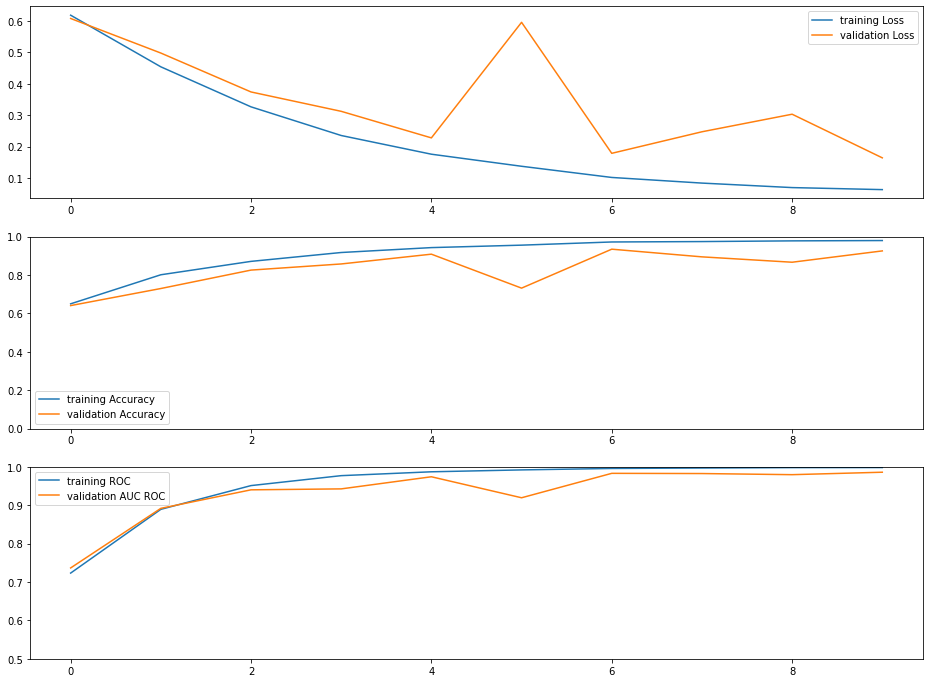

In [83]:
mobileVit1 = doExperiment(MobileViT2(image_size = (128, 128),
                        dims = [32, 48, 64],
                        channels = [32, 32, 48, 96, 96],
                        num_classes = 1,
                        patch_size=(16, 16),
                        kernel_size=3,
                        depths=(2, 4, 2)), 
             learning_rate=1e-4,
             input_size=(1,128,128),
             clean_every=500,
             epochs=10,
             nameOfModel="MobileViT5_AUC={}.pth")

## Simple ViT

### Architecture

### Experiment 1